## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt
import datetime as dt
import re

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 500)
%matplotlib inline

## Read data

In [2]:
df_twn_to_hkg = pd.read_csv('../data/admin_twn_to_hkg.csv', index_col=0)
df_twn_to_hkg.head()

,flight_id,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_flight_duration,route,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals
8,c36108c,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,7500.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-19 10:21:53,2017-01-19 10:00:00,29
46,c4fa940,CPA565,Airbus A330-343,B-HLV,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.485757e+09,1.485764e+09,1.485757e+09,NaN,5360.0,2017-01-30 06:15:00,2017-01-30 08:20:00,2017-01-30 06:21:37,NaN,7500.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-30 07:50:57,2017-01-30 07:00:00,28
65,c3ca5da,CAL909,Airbus A330-302,B-18301,China Airlines,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.485053e+09,1.485060e+09,1.485055e+09,NaN,5423.0,2017-01-22 02:40:00,2017-01-22 04:40:00,2017-01-22 03:16:07,NaN,7200.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-22 04:46:30,2017-01-22 04:00:00,28
84,c121d55,CPA403,Airbus A340-313,B-HXH,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483492e+09,1.483499e+09,1.483493e+09,1.483499e+09,5615.0,2017-01-04 01:10:00,2017-01-04 03:10:00,2017-01-04 01:20:58,2017-01-04 02:57:41,7200.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-04 02:54:33,2017-01-04 02:00:00,29
85,c464a13,CPA405,Airbus A350-941,B-LRB,Cathay Pacific,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.485419e+09,1.485426e+09,1.485419e+09,NaN,5550.0,2017-01-26 08:20:00,2017-01-26 10:25:00,2017-01-26 08:27:11,NaN,7500.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-26 09:59:41,2017-01-26 09:00:00,28


In [3]:
df_twn_to_hkg.dtypes

flight_id                            object
flight_callsign                      object
aircraft_model                       object
aircraft_registration                object
airline                              object
origin                               object
destination                          object
scheduled_departure_utc             float64
scheduled_arrival_utc               float64
real_departure_utc                  float64
estimated_arrival_utc               float64
real_flight_duration                float64
scheduled_departure_dt               object
scheduled_arrival_dt                 object
real_departure_dt                    object
estimated_arrival_dt                 object
scheduled_flight_duration           float64
route                                object
forecasted_arrival_dt                object
forecasted_arrival_dt_nearest_hr     object
arrivals                              int64
dtype: object

## Dates

**Convert to datetime**

In [4]:
df_twn_to_hkg['scheduled_departure_dt'] = pd.to_datetime(df_twn_to_hkg['scheduled_departure_dt'])
df_twn_to_hkg['scheduled_arrival_dt'] = pd.to_datetime(df_twn_to_hkg['scheduled_arrival_dt'])
df_twn_to_hkg['real_departure_dt'] = pd.to_datetime(df_twn_to_hkg['real_departure_dt'])
df_twn_to_hkg['estimated_arrival_dt'] = pd.to_datetime(df_twn_to_hkg['estimated_arrival_dt'])
df_twn_to_hkg['forecasted_arrival_dt'] = pd.to_datetime(df_twn_to_hkg['forecasted_arrival_dt'])
df_twn_to_hkg['forecasted_arrival_dt_nearest_hr'] = pd.to_datetime(df_twn_to_hkg['forecasted_arrival_dt_nearest_hr'])

In [5]:
df_twn_to_hkg.isnull().sum()

flight_id                             0
flight_callsign                       0
aircraft_model                        0
aircraft_registration                 0
airline                               0
origin                                0
destination                           0
scheduled_departure_utc              31
scheduled_arrival_utc                31
real_departure_utc                    3
estimated_arrival_utc               772
real_flight_duration                  0
scheduled_departure_dt               31
scheduled_arrival_dt                 31
real_departure_dt                     0
estimated_arrival_dt                772
scheduled_flight_duration             0
route                                 0
forecasted_arrival_dt                 0
forecasted_arrival_dt_nearest_hr      0
arrivals                              0
dtype: int64

## Factor weather in

In [6]:
df_hkg_weather = pd.read_csv('../data/metar-vhhh-clean.csv', index_col=0)
df_hkg_weather.head(2)

,timestamp,station,lon,lat,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
0,2016-12-31 00:00:00,VHHH,113.9219,22.3094,60.8,50.0,67.54,110,4.0,30.24,4.97,0,FEW,4500,NaN,60.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-12-31 00:30:00,VHHH,113.9219,22.3094,64.4,51.8,63.60,110,2.0,30.24,4.97,0,FEW,4500,NaN,64.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_hkg_weather.drop(columns=['station', 'lon', 'lat'], inplace=True)
df_hkg_weather['timestamp'] = pd.to_datetime(df_hkg_weather['timestamp'])
df_hkg_weather.rename(columns={'timestamp': 'timestamp_dt_weather'}, inplace=True)

In [8]:
df_twn_to_hkg = pd.merge(df_twn_to_hkg,
                         df_hkg_weather,
                         left_on='forecasted_arrival_dt_nearest_hr',
                         right_on='timestamp_dt_weather')

## Trails

In [10]:
trails_twn_to_hkg = pd.read_feather('../data/trails-twn-to-hkg.feather')

## Merge trails and df_twn_hkg

In [11]:
trails_twn_to_hkg[trails_twn_to_hkg.flight_id.isin(df_twn_to_hkg.flight_id.unique())].shape

(289712, 8)

In [12]:
combined_arrivals_at_hkg = pd.merge(trails_twn_to_hkg,
                                    df_twn_to_hkg,
                                    on='flight_id')
# del trails, df_twn_hkg
combined_arrivals_at_hkg.shape

(289712, 54)

In [13]:
combined_arrivals_at_hkg.head(2)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_flight_duration,route,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp_dt_weather,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS
0,c36108c,1484814608,25.078995,121.237640,0,317,0,2017-01-19 08:30:08,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,7500.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-19 10:21:53,2017-01-19 10:00:00,29,2017-01-19 10:00:00,69.8,62.6,77.9,310,5.0,30.06,2.36,0,FEW,1800,HZ,69.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,c36108c,1484814671,25.078762,121.237846,0,317,9,2017-01-19 08:31:11,CPA405,Airbus A330-343,B-HLU,Cathay Pacific (Oneworld livery),Taiwan Taoyuan International Airport,Hong Kong International Airport,1.484814e+09,1.484822e+09,1.484816e+09,1.484821e+09,5550.0,2017-01-19 08:20:00,2017-01-19 10:25:00,2017-01-19 08:49:23,2017-01-19 10:18:40,7500.0,Taiwan Taoyuan International Airport -> Hong K...,2017-01-19 10:21:53,2017-01-19 10:00:00,29,2017-01-19 10:00:00,69.8,62.6,77.9,310,5.0,30.06,2.36,0,FEW,1800,HZ,69.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
combined_arrivals_at_hkg.sort_values(by=['flight_id', 'timestamp_utc'],
                                     inplace=True)

In [15]:
combined_arrivals_at_hkg[combined_arrivals_at_hkg.duplicated(subset=['flight_id', 'timestamp_utc'])].sort_values(by='flight_id')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_flight_duration,route,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp_dt_weather,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS


## Plot of all flights arriving at Hong Kong International Airport

In [16]:
# Reference: https://pbpython.com/pandas-qcut-cut.html
# Reference: https://stackoverflow.com/questions/50145702/pandas-cut-doesnt-bin-zero-values
cut_labels = ['0 <= speed <= 100', 
              '100 < speed <= 200',
              '200 < speed <= 300',
              '300 < speed <= 400',
              '400 < speed <= 500',
              '500 < speed <= 600',
              '600 < speed <= 700',
              '700 < speed <= 800']
cut_bins = [-np.inf, 100, 200, 300, 400, 500, 600, 700, 800]
combined_arrivals_at_hkg['speed_interval'] = pd.cut(combined_arrivals_at_hkg['speed'], bins=cut_bins, labels=cut_labels)

# pd.cut(combined_jkt_sin['speed'], bins=np.linspace(0, 800, 9))

## Handling outliers

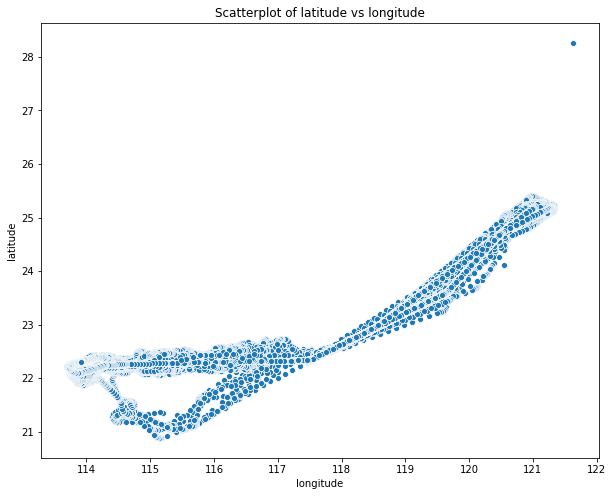

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Scatterplot of latitude vs longitude')
sns.scatterplot(ax = ax, x='longitude', y='latitude', data=combined_arrivals_at_hkg)
plt.show()
fig.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('01-scatterplot-lat-lon'), transparent=True)

In [18]:
combined_arrivals_at_hkg['time_since_real_departure'] = combined_arrivals_at_hkg['timestamp_utc'] - combined_arrivals_at_hkg['real_departure_utc']

In [19]:
combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['latitude'] > 28, 
                             trails_twn_to_hkg.columns]

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0,2017-01-17 14:16:43


In [20]:
combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['flight_id'] == 'c31cf95', 
                             trails_twn_to_hkg.columns].sort_values(by='timestamp_utc').head(5)

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt
27371,c31cf95,1484662603,28.258541,121.633163,11600,8,0,2017-01-17 14:16:43
27372,c31cf95,1484662641,24.921299,120.893318,19450,256,0,2017-01-17 14:17:21
27373,c31cf95,1484662667,24.853016,120.848541,20684,230,390,2017-01-17 14:17:47
27374,c31cf95,1484662677,24.837517,120.830132,21338,219,454,2017-01-17 14:17:57
27375,c31cf95,1484662694,24.831850,120.808067,22190,258,329,2017-01-17 14:18:14


In [21]:
# Drop outlier
combined_arrivals_at_hkg.drop(index=27371, inplace=True)

## Shift latitude and longitude by 1 for comparison of distance

In [22]:
unique_flight_ids = combined_arrivals_at_hkg.flight_id.unique().tolist()

df_prev_lat_lon = pd.DataFrame(columns=['flight_id', 'timestamp_utc', 'prev_latitude', 'prev_longitude'])

for flight_id in unique_flight_ids:
    dummy_df = combined_arrivals_at_hkg.loc[combined_arrivals_at_hkg['flight_id'] == flight_id, 
                                            ['flight_id', 'timestamp_utc', 'latitude', 'longitude']]
    dummy_df[['latitude', 'longitude']] = dummy_df[['latitude', 'longitude']].shift(1)
    dummy_df.rename(columns={'latitude': 'prev_latitude',
                             'longitude': 'prev_longitude'}, inplace=True)
    df_prev_lat_lon = pd.concat([df_prev_lat_lon, dummy_df])
df_prev_lat_lon

,flight_id,timestamp_utc,prev_latitude,prev_longitude
87482,c0aabc0,1483193923,NaN,NaN
87483,c0aabc0,1483193942,25.089270,121.240158
87484,c0aabc0,1483194080,25.089512,121.240349
87485,c0aabc0,1483194271,25.089546,121.240372
87486,c0aabc0,1483194304,25.089550,121.240372
...,...,...,...,...
227507,c52959e,1485870339,22.308723,113.916298
227508,c52959e,1485870348,22.308483,113.916603
227509,c52959e,1485870355,22.308449,113.916817
227510,c52959e,1485870366,22.308659,113.916946


In [23]:
merged_df = pd.merge(combined_arrivals_at_hkg,
                     df_prev_lat_lon,
                     how='left',
                     left_on=['flight_id', 'timestamp_utc'],
                     right_on=['flight_id', 'timestamp_utc'])
merged_df.shape

(289711, 58)

In [24]:
merged_df.to_feather('../data/merged_twn_to_hkg.feather')

In [25]:
selected_col = trails_twn_to_hkg.columns.tolist()
selected_col.extend(['real_flight_duration', 'real_departure_utc', 'real_departure_dt', 
                     'scheduled_departure_dt', 'scheduled_arrival_dt',
                     'time_since_real_departure', 'estimated_arrival_dt'])

**altitude > 0 but speed <= 0. Possibly erroneous**

In [26]:
merged_df.loc[(merged_df['speed'] <= 0) & (merged_df['altitude'] > 0), 
              'flight_id'].unique()

array(['c31cf95', 'c33e9e8', 'c4490d9'], dtype=object)

In [27]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95'].shape

(68, 58)

In [28]:
merged_df.loc[merged_df['flight_id'] == 'c31cf95', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
142344,c31cf95,1484662641,24.921299,120.893318,19450,256,0,2017-01-17 14:17:21,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,404.0,2017-01-17 15:35:03
142345,c31cf95,1484662667,24.853016,120.848541,20684,230,390,2017-01-17 14:17:47,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,430.0,2017-01-17 15:35:03
142346,c31cf95,1484662677,24.837517,120.830132,21338,219,454,2017-01-17 14:17:57,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,440.0,2017-01-17 15:35:03
142347,c31cf95,1484662694,24.831850,120.808067,22190,258,329,2017-01-17 14:18:14,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,457.0,2017-01-17 15:35:03
142348,c31cf95,1484662709,24.831102,120.788239,22980,287,301,2017-01-17 14:18:29,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,472.0,2017-01-17 15:35:03
142349,c31cf95,1484662719,24.845474,120.779282,23427,320,348,2017-01-17 14:18:39,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,482.0,2017-01-17 15:35:03
142350,c31cf95,1484662729,24.866079,120.764854,24134,330,404,2017-01-17 14:18:49,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,492.0,2017-01-17 15:35:03
142351,c31cf95,1484662736,24.871128,120.760094,24283,319,378,2017-01-17 14:18:56,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,499.0,2017-01-17 15:35:03
142352,c31cf95,1484662742,24.881048,120.749977,24514,318,374,2017-01-17 14:19:02,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,505.0,2017-01-17 15:35:03
142353,c31cf95,1484662752,24.888002,120.739769,24800,309,352,2017-01-17 14:19:12,4724.0,1.484662e+09,2017-01-17 14:10:37,2017-01-17 14:00:00,2017-01-17 15:30:00,515.0,2017-01-17 15:35:03


In [79]:
merged_df.loc[merged_df['flight_id'] == 'c33e9e8', 
              selected_col].sort_values(by='timestamp_utc')[['flight_id', 'timestamp_dt', 'real_departure_dt',
                                                             'time_since_real_departure',
                                                             'latitude', 'longitude', 'altitude',
                                                             'heading', 'speed']]

,flight_id,timestamp_dt,real_departure_dt,time_since_real_departure,latitude,longitude,altitude,heading,speed
152158,c33e9e8,2017-01-18 11:48:41,2017-01-18 11:53:45,-304.0,25.059814,121.229324,0,225,21
152159,c33e9e8,2017-01-18 11:52:53,2017-01-18 11:53:45,-52.0,25.053635,121.227264,0,50,20
152160,c33e9e8,2017-01-18 11:52:59,2017-01-18 11:53:45,-46.0,25.054150,121.227951,0,50,46
152161,c33e9e8,2017-01-18 11:53:09,2017-01-18 11:53:45,-36.0,25.056210,121.230698,0,50,88
152162,c33e9e8,2017-01-18 11:53:19,2017-01-18 11:53:45,-26.0,25.059471,121.234993,0,50,120
152163,c33e9e8,2017-01-18 11:53:25,2017-01-18 11:53:45,-20.0,25.061531,121.237564,0,50,140
152164,c33e9e8,2017-01-18 11:53:40,2017-01-18 11:53:45,-5.0,25.067184,121.244965,0,49,0
152165,c33e9e8,2017-01-18 11:53:46,2017-01-18 11:53:45,1.0,25.070297,121.248878,50,48,0
152166,c33e9e8,2017-01-18 11:53:54,2017-01-18 11:53:45,9.0,25.076294,121.256813,525,50,0
152167,c33e9e8,2017-01-18 11:54:00,2017-01-18 11:53:45,15.0,25.079367,121.260925,775,51,0


Don't drop c33e9e8 because the records with altitude > 0 but speed = 0 are at the start of the flight

In [30]:
merged_df.loc[merged_df['flight_id'] == 'c4490d9', selected_col].sort_values(by='timestamp_utc')

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,real_flight_duration,real_departure_utc,real_departure_dt,scheduled_departure_dt,scheduled_arrival_dt,time_since_real_departure,estimated_arrival_dt
228743,c4490d9,1485359074,24.110689,120.543747,14325,0,0,2017-01-25 15:44:34,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,411.0,2017-01-25 17:04:21
228744,c4490d9,1485359127,25.075544,120.854759,22050,343,0,2017-01-25 15:45:27,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,464.0,2017-01-25 17:04:21
228745,c4490d9,1485359149,25.054354,120.823624,23325,230,371,2017-01-25 15:45:49,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,486.0,2017-01-25 17:04:21
228746,c4490d9,1485359176,25.024464,120.793999,24450,219,471,2017-01-25 15:46:16,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,513.0,2017-01-25 17:04:21
228747,c4490d9,1485359182,25.019495,120.780548,25614,219,471,2017-01-25 15:46:22,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,519.0,2017-01-25 17:04:21
228748,c4490d9,1485359244,24.922564,120.683693,28925,212,591,2017-01-25 15:47:24,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,581.0,2017-01-25 17:04:21
228749,c4490d9,1485359297,24.815313,120.600418,31319,220,533,2017-01-25 15:48:17,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,634.0,2017-01-25 17:04:21
228750,c4490d9,1485359338,24.738972,120.536194,33398,244,435,2017-01-25 15:48:58,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,675.0,2017-01-25 17:04:21
228751,c4490d9,1485359356,24.718842,120.508430,33900,223,433,2017-01-25 15:49:16,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,693.0,2017-01-25 17:04:21
228752,c4490d9,1485359408,24.714375,120.503502,33950,223,433,2017-01-25 15:50:08,4663.0,1.485359e+09,2017-01-25 15:37:43,2017-01-25 14:00:00,2017-01-25 15:30:00,745.0,2017-01-25 17:04:21


In [31]:
# Drop flights with flight_id c4490d9, c31cf95. 
# Reason being that the are multiple records with altitude > 0 but speed = 0 in between records
# merged_df.drop(merged_df[(merged_df['flight_id'].isin(['c4490d9', 'c31cf95']))].index, inplace=True)

## Filter flights from TWN that landed in HKG

In [32]:
unique_flight_ids = merged_df['flight_id'].unique()
incomplete_flights = []
complete_flights = []
filtered_df = pd.DataFrame(columns=merged_df.columns.tolist() + ['calculated_flight_duration'])

for unique_flight_id in unique_flight_ids:
    # Filter to get records where 
    # plane has taken off; i.e. speed > 0
    # plane's time_since_real_departure >= 0
    temp = merged_df.loc[(merged_df['flight_id'] == unique_flight_id) &
                         (merged_df['time_since_real_departure'] >= 0) &
                         (merged_df['speed'] > 0)].sort_values(by='timestamp_utc')
#                          , selected_col].sort_values(by='timestamp_utc')
    
    # time_since_real_departure after arrival 
    # where altitude = 0
#     if 0 in temp['altitude'][:10]:
#         print("ZERO ALTITUDE IN FIRST 10")
    possible_arrival_df = temp.loc[(temp['altitude'] == 0) & 
                                   (temp['time_since_real_departure'] > 11)] # setting to 0 will reveal that some planes did not take off successfully at the first attempt; > 0 then back to 0
    
    if possible_arrival_df.shape[0] > 0:
        complete_flights.append(unique_flight_id)
        calculated_flight_duration = possible_arrival_df.iloc[0]['time_since_real_departure']
        temp = temp[temp['time_since_real_departure'] <= calculated_flight_duration]
        temp = temp.assign(calculated_flight_duration=calculated_flight_duration)
        filtered_df = filtered_df.append(temp, ignore_index=True)
    else:
        incomplete_flights.append(unique_flight_id)

print("Number of complete flights: {}".format(len(complete_flights)))
print("Number of incomplete flights: {}".format(len(incomplete_flights)))

Number of complete flights: 788
Number of incomplete flights: 362


In [33]:
filtered_df.head()

,flight_id,timestamp_utc,latitude,longitude,altitude,heading,speed,timestamp_dt,flight_callsign,aircraft_model,aircraft_registration,airline,origin,destination,scheduled_departure_utc,scheduled_arrival_utc,real_departure_utc,estimated_arrival_utc,real_flight_duration,scheduled_departure_dt,scheduled_arrival_dt,real_departure_dt,estimated_arrival_dt,scheduled_flight_duration,route,forecasted_arrival_dt,forecasted_arrival_dt_nearest_hr,arrivals,timestamp_dt_weather,air_temp,dewpoint_temp,rel_humidity,wind_dir,wind_speed,altimeter_pressure,visibility,gust_speed,sky_level_1_coverage,sky_level_1_altitude,weather_codes,apparent_temp,weather_codes_+SHRA,weather_codes_+TSRA,weather_codes_-BR,weather_codes_-DZ,weather_codes_-RA,weather_codes_-SHRA,weather_codes_BR,weather_codes_DZ,weather_codes_HZ,weather_codes_RA,weather_codes_SHRA,weather_codes_TSRA,weather_codes_VCTS,speed_interval,time_since_real_departure,prev_latitude,prev_longitude,calculated_flight_duration
0,c0aabc0,1483194745,25.090073,121.237190,950,46,143,2016-12-31 14:32:25,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaT,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,20.0,25.072781,121.218529,5115.0
1,c0aabc0,1483194754,25.093964,121.242012,1375,48,145,2016-12-31 14:32:34,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaT,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,29.0,25.090073,121.237190,5115.0
2,c0aabc0,1483194770,25.101013,121.251183,2100,50,153,2016-12-31 14:32:50,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaT,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,45.0,25.093964,121.242012,5115.0
3,c0aabc0,1483194776,25.103577,121.254631,2300,50,159,2016-12-31 14:32:56,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaT,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,51.0,25.101013,121.251183,5115.0
4,c0aabc0,1483194782,25.107010,121.259155,2525,50,171,2016-12-31 14:33:02,CAL5821,Boeing 747-409(F),B-18717,China Airlines Cargo,Taiwan Taoyuan International Airport,Hong Kong International Airport,1.483193e+09,1.483198e+09,1.483195e+09,NaN,4663.0,2016-12-31 14:00:00,2016-12-31 15:30:00,2016-12-31 14:32:05,NaT,5400.0,Taiwan Taoyuan International Airport -> Hong K...,2016-12-31 15:49:48,2016-12-31 15:00:00,6,2016-12-31 15:00:00,66.2,59.0,77.6,110,10.0,30.18,6.21,0,FEW,2500,NaN,66.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100 < speed <= 200,57.0,25.103577,121.254631,5115.0


In [34]:
# Convert to int
for col in ['altitude', 'heading', 'speed', 'timestamp_utc', 'arrivals', 'wind_dir', 'gust_speed'
#            'scheduled_arrival_year', 'scheduled_arrival_month', 
#             'scheduled_arrival_day', 'scheduled_departure_year', 
#             'scheduled_departure_month', 'scheduled_departure_day'
           ]:
    filtered_df[col] = filtered_df[col].astype(int)

In [35]:
filtered_df['calculated_flight_duration'].value_counts().sort_index()

4274.0    141
4503.0    185
4551.0    162
4590.0    176
4593.0    185
         ... 
6781.0    314
6833.0    317
6882.0    281
6930.0    316
6973.0    356
Name: calculated_flight_duration, Length: 632, dtype: int64

In [36]:
filtered_df['calculated_time_before_arrival'] = filtered_df['calculated_flight_duration'] - filtered_df['time_since_real_departure']

In [37]:
hkg_lat, hkg_lon = 22.308046, 113.918480
twn_lat, twn_lon = 25.0725, 121.2210

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

filtered_df['displacement_to_hkg'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           hkg_lon, hkg_lat), 
                                                                     axis=1)

filtered_df['displacement_fr_twn'] = filtered_df.apply(lambda x: haversine(x.longitude,
                                                                           x.latitude,
                                                                           twn_lon, twn_lat), 
                                                                     axis=1)

In [38]:
(filtered_df['time_since_real_departure'] / 60).max()

116.21666666666667

In [39]:
cut_labels = ['0 <= min <= 10', 
              '10 < min <= 20',
              '20 < min <=30',
              '30 < min <= 40',
              '40 < min <= 50',
              '50 < min <= 60',
              '60 < min <= 70',
              '70 < min <= 80',
              '80 < min <= 90',
              '90 < min <= 100',
              '100 < min <= 110',
              '110 < min <= 120'
             ]
cut_bins = [-np.inf, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
filtered_df['minutes_since_real_departure_interval'] = pd.cut((filtered_df['time_since_real_departure'] / 60), 
                                                               bins=cut_bins, labels=cut_labels)

In [40]:
filtered_df['minutes_since_real_departure_interval'].value_counts().sort_index()

0 <= min <= 10      29067
10 < min <= 20       8202
20 < min <=30        8881
30 < min <= 40       7532
40 < min <= 50       8446
50 < min <= 60       8480
60 < min <= 70      14669
70 < min <= 80      34607
80 < min <= 90      32189
90 < min <= 100     15485
100 < min <= 110     3880
110 < min <= 120      328
Name: minutes_since_real_departure_interval, dtype: int64

In [41]:
filtered_df.groupby(['minutes_since_real_departure_interval', 'flight_id'])['displacement_fr_twn'] \
.max().reset_index()

,minutes_since_real_departure_interval,flight_id,displacement_fr_twn
0,0 <= min <= 10,c0aabc0,53.937310
1,0 <= min <= 10,c0ab750,63.586828
2,0 <= min <= 10,c0ac71c,74.637064
3,0 <= min <= 10,c0b5e1f,58.459735
4,0 <= min <= 10,c0b6e4a,50.094154
...,...,...,...
9451,110 < min <= 120,c524f43,NaN
9452,110 < min <= 120,c5285c7,NaN
9453,110 < min <= 120,c528666,NaN
9454,110 < min <= 120,c528860,NaN


In [42]:
filtered_df['calculated_flight_duration'].sort_values() / 60

23979      71.233333
23960      71.233333
23961      71.233333
23962      71.233333
23963      71.233333
             ...    
131220    116.216667
131219    116.216667
131218    116.216667
131238    116.216667
131172    116.216667
Name: calculated_flight_duration, Length: 171766, dtype: float64

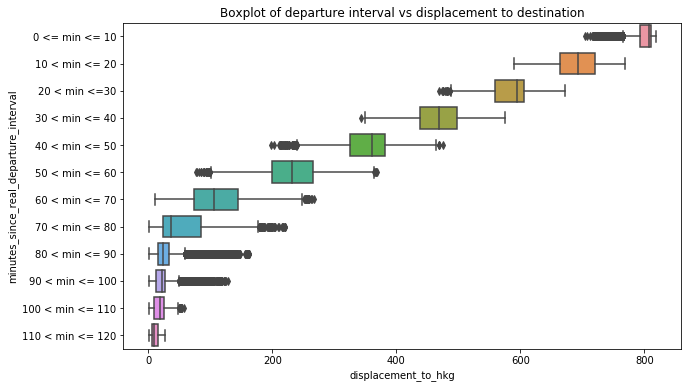

In [43]:
plt.figure(figsize=(10, 6))
plt.title('Boxplot of departure interval vs displacement to destination')
sns.boxplot(x='displacement_to_hkg',
            y='minutes_since_real_departure_interval',
            data=filtered_df)
plt.show()
fig.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('02-boxplot-interval_vs_disp'), transparent=True)

In [44]:
numeric_features = filtered_df.dtypes[(filtered_df.dtypes == np.int)|(filtered_df.dtypes == np.float)]
numeric_features = numeric_features.index.tolist()
numeric_features.remove('calculated_time_before_arrival')
print(numeric_features)
target_col = 'calculated_time_before_arrival'

['timestamp_utc', 'latitude', 'longitude', 'altitude', 'heading', 'speed', 'scheduled_departure_utc', 'scheduled_arrival_utc', 'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration', 'scheduled_flight_duration', 'arrivals', 'air_temp', 'dewpoint_temp', 'rel_humidity', 'wind_dir', 'wind_speed', 'altimeter_pressure', 'visibility', 'gust_speed', 'apparent_temp', 'weather_codes_+SHRA', 'weather_codes_+TSRA', 'weather_codes_-BR', 'weather_codes_-DZ', 'weather_codes_-RA', 'weather_codes_-SHRA', 'weather_codes_BR', 'weather_codes_DZ', 'weather_codes_HZ', 'weather_codes_RA', 'weather_codes_SHRA', 'weather_codes_TSRA', 'weather_codes_VCTS', 'time_since_real_departure', 'prev_latitude', 'prev_longitude', 'calculated_flight_duration', 'displacement_to_hkg', 'displacement_fr_twn']


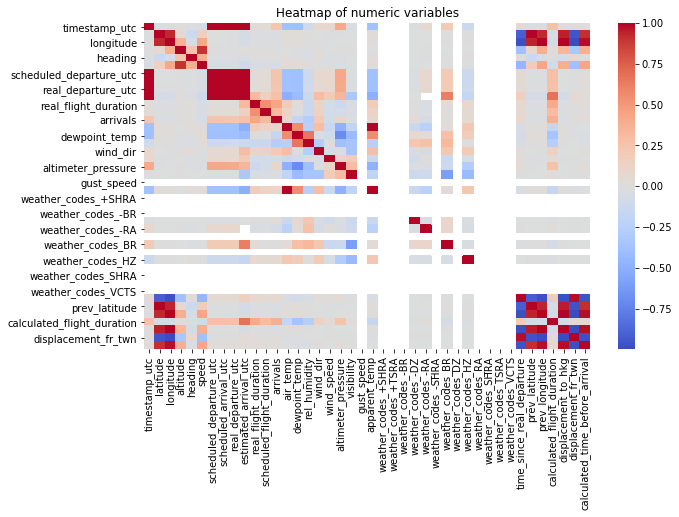

In [45]:
plt.figure(figsize=(10, 6))
plt.title('Heatmap of numeric variables')
sns.heatmap(filtered_df[numeric_features + [target_col]].corr(), annot=False, cmap='coolwarm')
plt.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('03-heatmap'), transparent=True)

## Callsign

In [47]:
df_twn_hkg_with_flight_dur = filtered_df

In [48]:
df_twn_hkg_with_flight_dur['flight_callsign'] = df_twn_hkg_with_flight_dur['flight_callsign'].str.extract(r'([A-Z]*)')
df_twn_hkg_with_flight_dur['flight_callsign'].value_counts()

CPA    63943
CAL    41217
EVA    34877
CRK    18069
HDA     6243
AHK     3959
FDX     1236
PAC      733
UPS      648
BR       420
NCA      230
HX       191
Name: flight_callsign, dtype: int64

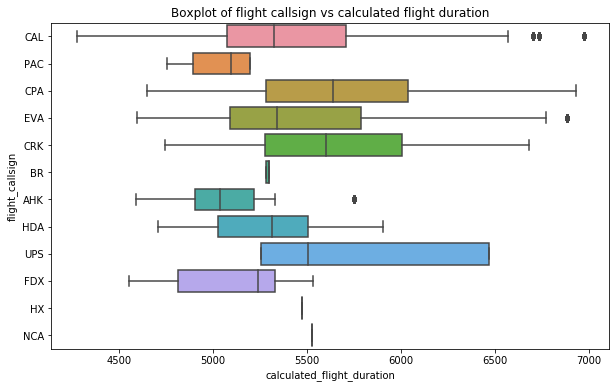

In [49]:
plt.figure(figsize=(10, 6))
plt.title('Boxplot of flight callsign vs calculated flight duration')
sns.boxplot(y='flight_callsign',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()
fig.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('04-boxplot-callsign_vs_duration'), transparent=True)

## Airline

In [50]:
df_twn_hkg_with_flight_dur['airline'].value_counts(dropna=False).values.sum()

171766

In [52]:
df_twn_hkg_with_flight_dur['airline'] = df_twn_hkg_with_flight_dur['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())

In [53]:
df_twn_hkg_with_flight_dur['airline'].value_counts()

Cathay Pacific           59224
China Airlines           33925
EVA Air                  28509
Hong Kong Airlines       18260
China Airlines Cargo      6696
Cathay Dragon             6243
Air Hong Kong             5135
EVA Air Cargo             4810
Cathay Pacific Cargo      2745
Eva Air                   1978
FedEx                     1236
EMPTY                     1038
Polar Air Cargo            733
UPS                        648
Mandarin Airlines          356
Nippon Cargo Airlines      230
Name: airline, dtype: int64

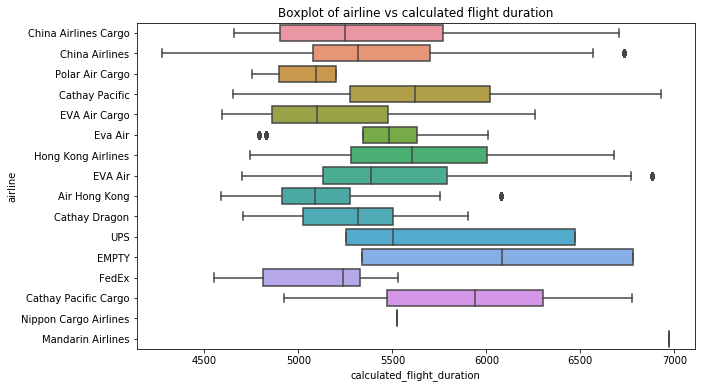

In [54]:
plt.figure(figsize=(10, 6))
plt.title('Boxplot of airline vs calculated flight duration')
sns.boxplot(y='airline',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()
fig.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('05-boxplot-airline_vs_duration'), transparent=True)

## Aircraft Model

In [55]:
df_twn_hkg_with_flight_dur.aircraft_model.value_counts().sort_index()

Airbus A3004F-605R            939
Airbus A300B4-622R(F)         743
Airbus A300F4-605R           3453
Airbus A320-232              2389
Airbus A321-211             25114
Airbus A321-231              2249
Airbus A330-203              1721
Airbus A330-223              3663
Airbus A330-243              4533
Airbus A330-243F             2046
Airbus A330-302             13200
Airbus A330-342              7572
Airbus A330-343             33232
Airbus A340-313              5793
Airbus A350-941             20118
Boeing 737-809               1563
Boeing 737-8AL               1866
Boeing 737-8FH                278
Boeing 737-8MA                859
Boeing 737-8Q8                374
Boeing 737-8SH                356
Boeing 747-409                202
Boeing 747-409(F)            6696
Boeing 747-412(BCF)           274
Boeing 747-45E                224
Boeing 747-45E(BDSF)         2403
Boeing 747-45EF(SCD)         2407
Boeing 747-467F(ER)          2107
Boeing 747-46N(F)             556
Boeing 747-47U

In [56]:
def get_aircraft_model(aircraft):
    if aircraft.find('Airbus') != -1:
        return aircraft[:11]
    elif aircraft.find('Boeing') != -1:
        return aircraft[:10]
    else:
        return aircraft
    
df_twn_hkg_with_flight_dur.aircraft_model = df_twn_hkg_with_flight_dur.aircraft_model.map(get_aircraft_model)

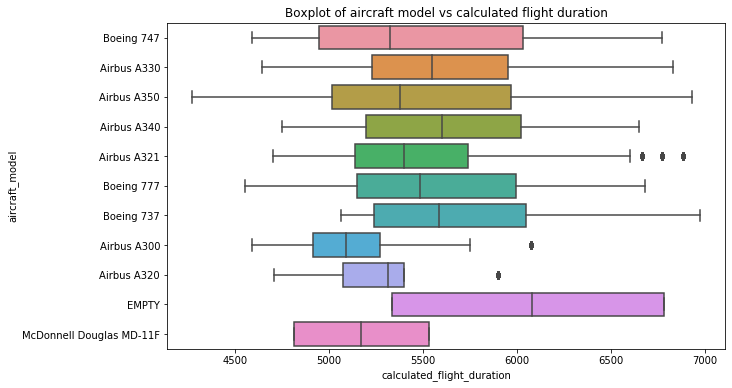

In [57]:
plt.figure(figsize=(10, 6))
plt.title('Boxplot of aircraft model vs calculated flight duration')
sns.boxplot(y='aircraft_model',
            x='calculated_flight_duration',
            data=df_twn_hkg_with_flight_dur)
plt.show()
fig.savefig('../images/01d-eda-hkg-incoming-flights/{}.png'.format('06-boxplot-model_vs_duration'), transparent=True)

## Aircraft Registration

In [58]:
df_twn_hkg_with_flight_dur.aircraft_registration.value_counts().sort_index()

B-16201     417
B-16203    1950
B-16206    1277
B-16208     211
B-16212     213
B-16215    1628
B-16216    2203
B-16217     799
B-16218    1978
B-16219    2085
B-16220     679
B-16221    2982
B-16222    1454
B-16223    1806
B-16225    2246
B-16226    2177
B-16227    1009
B-16310     496
B-16311     218
B-16312    1007
B-16335     345
B-16336     202
B-16401     469
B-16406    1934
B-16410     224
B-16481    1148
B-16482     649
B-16483     610
B-16701     220
B-16702     722
B-16703     509
B-16708     174
B-16710     454
B-16712     228
B-16716     207
B-16717     367
B-18001     190
B-18007     204
B-18051     189
B-18053     205
B-18208     202
B-18301    1814
B-18302     928
B-18303     220
B-18306     189
B-18307     412
B-18308     384
B-18309    2589
B-18310     737
B-18312     445
B-18315     208
B-18316     201
B-18317     438
B-18351    1416
B-18352     767
B-18353     803
B-18355     443
B-18358     213
B-18359     228
B-18360     218
B-18605     231
B-18606     525
B-18609 

In [59]:
selected_features = ['latitude', 'longitude', 'altitude', 'heading', 'speed',
#                      'flight_callsign', 
#                      'aircraft_registration', 
                     'aircraft_model', 'airline']

nominal_features = [
    'flight_callsign', 
    'aircraft_registration',
    'aircraft_model', 
    'airline'
]

In [60]:
df_twn_hkg_with_flight_dur.columns

Index(['flight_id', 'timestamp_utc', 'latitude', 'longitude', 'altitude',
       'heading', 'speed', 'timestamp_dt', 'flight_callsign', 'aircraft_model',
       'aircraft_registration', 'airline', 'origin', 'destination',
       'scheduled_departure_utc', 'scheduled_arrival_utc',
       'real_departure_utc', 'estimated_arrival_utc', 'real_flight_duration',
       'scheduled_departure_dt', 'scheduled_arrival_dt', 'real_departure_dt',
       'estimated_arrival_dt', 'scheduled_flight_duration', 'route',
       'forecasted_arrival_dt', 'forecasted_arrival_dt_nearest_hr', 'arrivals',
       'timestamp_dt_weather', 'air_temp', 'dewpoint_temp', 'rel_humidity',
       'wind_dir', 'wind_speed', 'altimeter_pressure', 'visibility',
       'gust_speed', 'sky_level_1_coverage', 'sky_level_1_altitude',
       'weather_codes', 'apparent_temp', 'weather_codes_+SHRA',
       'weather_codes_+TSRA', 'weather_codes_-BR', 'weather_codes_-DZ',
       'weather_codes_-RA', 'weather_codes_-SHRA', 'weather_code

In [61]:
corr = filtered_df[numeric_features + [target_col]].corr()[target_col].sort_values()
corr[abs(corr.values) > 0.38]

displacement_fr_twn              -0.977494
time_since_real_departure        -0.964894
altitude                          0.388276
speed                             0.434193
latitude                          0.910920
prev_latitude                     0.915070
displacement_to_hkg               0.977985
prev_longitude                    0.981058
longitude                         0.981073
calculated_time_before_arrival    1.000000
Name: calculated_time_before_arrival, dtype: float64

## Save Data

In [62]:
filtered_df['flight_callsign'] = filtered_df['flight_callsign'].str.extract(r'([A-Z]*)')
filtered_df['airline'] = filtered_df['airline'].map(lambda x: re.sub(r'\([^)]*\)', '', x).strip())
filtered_df['aircraft_model'] = filtered_df.aircraft_model.map(get_aircraft_model)

In [63]:
filtered_df.to_csv('../data/filtered_flights_twn_hkg.csv')